In [7]:
# Mount Drive & Load Dataset
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/train.csv')

In [4]:
# Step 2: Preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [5]:
# Tokenization
X_train_text = df['comment_text'].values
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_text)
X = tokenizer.texts_to_sequences(X_train_text)
X = pad_sequences(X, maxlen=200)  # pad to same length

In [6]:
# Labels
y = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

In [7]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
# Step 3: Build Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

vocab_size = len(tokenizer.word_index) + 1

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='sigmoid'))  # Multi-label


In [13]:
# Step 4: Define Focal Loss
import tensorflow as tf
from keras import backend as K

def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return focal_loss_fixed


In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize and fit tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['comment_text'].values)

# Convert text to padded sequences
X = tokenizer.texts_to_sequences(df['comment_text'].values)
X = pad_sequences(X, maxlen=200)  # Adjust maxlen if needed

# Define labels
y = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
# Compiling the model
model.compile(
    loss=focal_loss(gamma=2.0, alpha=0.25),
    optimizer='adam',
    metrics=['accuracy']
)

# Fit the model and save the history
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=3,
    batch_size=64,
    verbose=1
)


Epoch 1/3
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 1204s 601ms/step - accuracy: 0.6908 - loss: 4.0183e-04 - val_accuracy: 0.9941 - val_loss: 5.5122e-10
Epoch 2/3
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 1243s 612ms/step - accuracy: 0.6983 - loss: 2.1259e-08 - val_accuracy: 0.9941 - val_loss: 3.5630e-11
Epoch 3/3
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 1246s 624ms/step - accuracy: 0.7265 - loss: 4.7648e-09 - val_accuracy: 0.9941 - val_loss: 6.4150e-12


In [23]:
from sklearn.metrics import classification_report

# Predict on validation data
y_pred = model.predict(X_val)

# Convert probabilities to binary (0/1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Define label columns
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Print classification report
print(classification_report(y_val, y_pred_binary, target_names=label_cols))

998/998 ━━━━━━━━━━━━━━━━━━━━ 36s 36ms/step
               precision    recall  f1-score   support

        toxic       0.10      1.00      0.17      3056
 severe_toxic       0.01      1.00      0.02       321
      obscene       0.05      1.00      0.10      1715
       threat       0.00      1.00      0.00        74
       insult       0.05      1.00      0.10      1614
identity_hate       0.01      1.00      0.02       294

    micro avg       0.04      1.00      0.07      7074
    macro avg       0.04      1.00      0.07      7074
 weighted avg       0.07      1.00      0.12      7074
  samples avg       0.04      0.10      0.05      7074



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

vocab_size = len(tokenizer.word_index) + 1

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128))  # you can remove input_length
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='sigmoid'))  # For multi-label output


In [17]:
# Custom focal loss definition
from keras import backend as K
import tensorflow as tf

def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return focal_loss_fixed

# Compile
model.compile(
    loss=focal_loss(gamma=2.0, alpha=0.25),
    optimizer='adam',
    metrics=['accuracy']
)

# Fit
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=3,
    batch_size=64,
    verbose=1
)


Epoch 1/3
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 1245s 620ms/step - accuracy: 0.4167 - loss: 4.1341e-04 - val_accuracy: 0.0039 - val_loss: 1.1840e-09
Epoch 2/3
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 1283s 621ms/step - accuracy: 0.4411 - loss: 2.3893e-08 - val_accuracy: 0.9941 - val_loss: 7.4911e-11
Epoch 3/3
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 1318s 639ms/step - accuracy: 0.4052 - loss: 5.5851e-09 - val_accuracy: 0.9941 - val_loss: 1.1060e-11


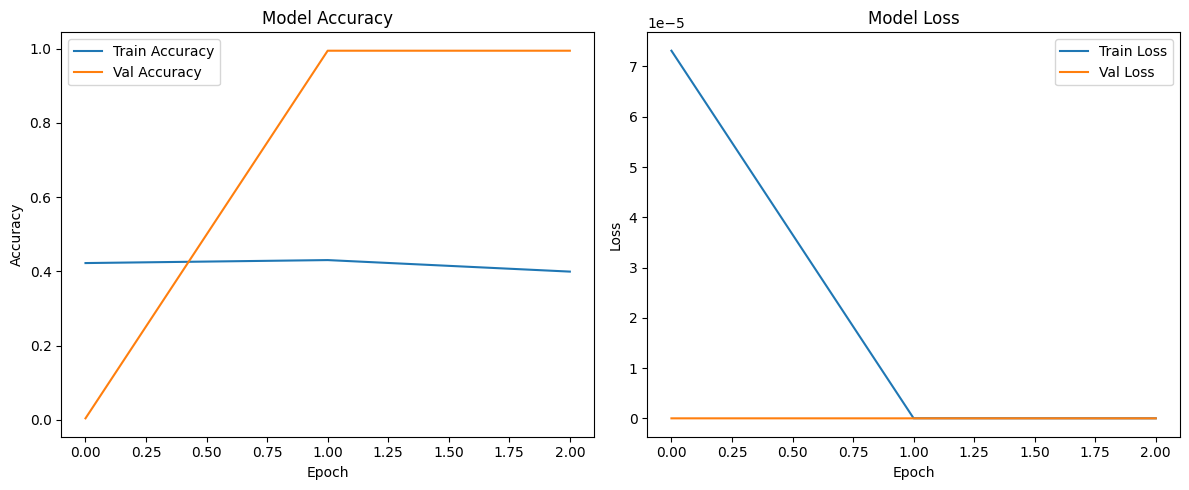

In [18]:
#Plot Training Accuracy and Loss
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [20]:
# Save the model in HDF5 format
model.save("toxic_comment_model.h5")

In [21]:
# Example new comments
new_comments = [
    "You are a horrible person.",
    "I hope you have a great day!",
    "That was a dumb thing to say."
]

# Tokenize and pad
new_seq = tokenizer.texts_to_sequences(new_comments)
new_padded = pad_sequences(new_seq, maxlen=200)

# Predict
new_preds = model.predict(new_padded)
new_labels = (new_preds > 0.5).astype(int)

# Output results
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for comment, preds in zip(new_comments, new_labels):
    print(f"\nComment: {comment}")
    for label, value in zip(label_cols, preds):
        print(f"{label}: {'Yes' if value == 1 else 'No'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Comment: You are a horrible person.
toxic: Yes
severe_toxic: Yes
obscene: Yes
threat: Yes
insult: Yes
identity_hate: Yes

Comment: I hope you have a great day!
toxic: Yes
severe_toxic: Yes
obscene: Yes
threat: Yes
insult: Yes
identity_hate: Yes

Comment: That was a dumb thing to say.
toxic: Yes
severe_toxic: Yes
obscene: Yes
threat: Yes
insult: Yes
identity_hate: Yes
